# White-box Attack on CIFAR10

In [4]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..') # For, jupyter_notebook
import torchattacks

## Load model and data

In [48]:
import torch
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = '../../640px-Grosser_Panda.JPG'
image = Image.open(image_path)
# Define a transform to convert the image to a Torch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Apply the transform to the image
image_tensor = transform(image)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=MEAN, std=STD)
])
images = transform(image)
images = images.unsqueeze(0)

In [64]:
target_id = 368
target_label = torch.zeros((1,1000))
target_label[:,target_id] = 1.0
gt_id = 388
gt_label = torch.zeros((1,1000))
gt_label[:,gt_id] = 1.0

In [50]:
#gibbon 368
#giant_panda 388

In [52]:
@torch.no_grad()
def get_accuracy(model, data_loader, atk=None, n_limit=1e10, device=None):
    model = model.eval()

    if device is None:
        device = next(model.parameters()).device

    correct = 0
    total = 0

    for images, labels in data_loader:

        X = images.to(device)
        Y = labels.to(device)

        if atk:
            X = atk(X, Y)

        pre = model(X)

        _, pre = torch.max(pre.data, 1)
        total += pre.size(0)
        correct += (pre == Y).sum()

        if total > n_limit:
            break

    return (100 * float(correct) / total)

In [154]:
from torchvision import models
from utils import get_imagenet_data, get_accuracy

#images, labels = get_imagenet_data()
#print('[Data loaded]')

device = "cpu"
model = models.resnet18(pretrained=True).to(device).eval()
res = model(images.to(device))
pred_id, pred_score = res.argmax(), res.max()
print(f"{pred_id}, {pred_score}")

388, 14.274852752685547


/home/mwm/anaconda3/envs/gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mwm/anaconda3/envs/gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Adversarial Attack (Non-targeted)

In [155]:
from torchattacks import PGD, FAB, OnePixel

In [156]:
atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(atk)

PGD(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=True, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


In [157]:
adv_images = atk(images, gt_label)

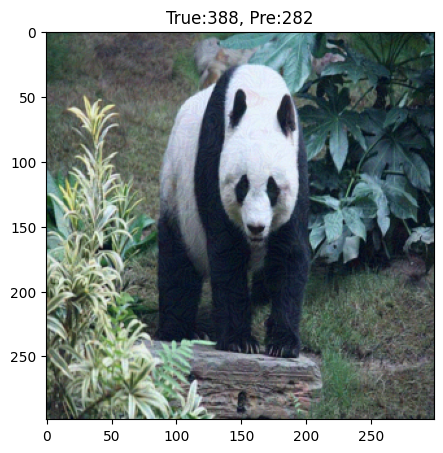

In [158]:
from utils import imshow, get_pred
idx = 0
pre = get_pred(model, adv_images[idx:idx+1], device)
imshow(adv_images[idx:idx+1], title="True:%d, Pre:%d"%(388, pre))

## Adversarial Attack (Targeted)

In [161]:
atk = PGD(model, eps=70/255, alpha=15/225, steps=50, random_start=True)
atk = FAB(model, norm='l1', steps=200, eps=16/255, n_restarts=50)
#atk = OnePixel(model, pixels=50)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
atk.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+368-labels))
print(atk)

Attack mode is changed to 'targeted(custom)'.
FAB(model_name=ResNet, device=cpu, attack_mode=targeted(custom), targeted=True, normalization_used=True, norm=l1, n_restarts=50, eps=0.06274509803921569, alpha_max=0.1, eta=1.05, beta=0.9, steps=200, verbose=False, seed=0, target_class=None, multi_targeted=False, n_target_classes=9)


In [162]:
adv_images = atk(images, gt_label)

In [166]:
adv_images[0]

tensor([[[-1.4843, -1.3815, -1.3815,  ..., -1.6213, -1.6384, -1.6898],
         [-1.3987, -1.2617, -1.2617,  ..., -1.5699, -1.4843, -1.6727],
         [-1.2959, -1.2445, -1.2274,  ..., -1.6384, -1.1075, -1.4672],
         ...,
         [-0.6452, -0.8507, -1.1760,  ..., -0.5767, -0.4739, -0.6281],
         [-0.6452, -0.9020, -0.7479,  ..., -1.0904, -0.7650, -1.0904],
         [-1.0048, -0.6965, -0.2342,  ..., -1.0219, -0.9192, -1.2617]],

        [[-0.9503, -0.8803, -0.8627,  ..., -1.2479, -1.2479, -1.2654],
         [-0.8803, -0.7577, -0.7402,  ..., -1.1429, -1.0203, -1.1954],
         [-0.7927, -0.7227, -0.7052,  ..., -1.1779, -0.5476, -0.8978],
         ...,
         [-0.5651, -0.7052, -1.0028,  ..., -0.4951, -0.3725, -0.5301],
         [-0.5651, -0.7752, -0.5651,  ..., -1.0028, -0.6352, -0.9853],
         [-0.9328, -0.5651, -0.0399,  ..., -0.8978, -0.7927, -1.1253]],

        [[-1.2467, -1.1770, -1.1944,  ..., -1.0550, -1.1770, -1.2641],
         [-1.1596, -1.0376, -1.0550,  ..., -0

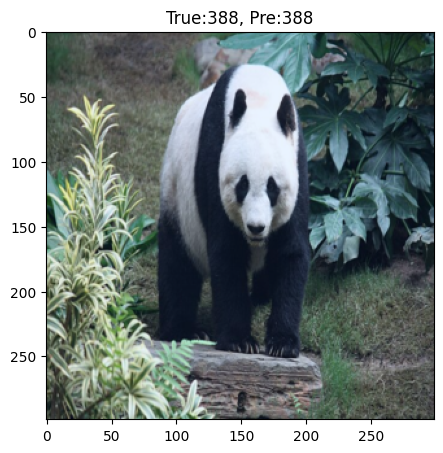

In [167]:
idx = 0
pre = get_pred(model, adv_images[idx:idx+1], device)
imshow(adv_images[0], title="True:%d, Pre:%d"%(388, pre))